In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.cluster import KMeans

sns.set(color_codes = True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [2]:
dir_path = '~/Documents/DATA_SCIENCE/Kroger_Retail_Dunnhumby/The-Complete-Journey/data/'

file1= dir_path + 'transaction_data.csv'
file2 = dir_path + 'hh_demographic.csv'
file3 = dir_path + 'coupon_redempt.csv'
file4= dir_path + 'coupon.csv'
file5 = dir_path + 'campaign_desc.csv'
file6 = dir_path + 'campaign_table.csv'
file7= dir_path + 'causal_data.csv'
file8 = dir_path + 'product.csv'


In [3]:
def load_data(filename):
    df = pd.read_csv(filename)
    df.columns = df.columns.str.lower()
    return df


In [4]:
# import data listings into dataframe
df_trans = load_data(file1)
df_trans.head()


,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [5]:
df_coupon_redempt = load_data(file3)
df_coupon_redempt.shape

(2318, 4)

In [6]:
df_coupon = load_data(file4)
df_coupon.head()

,coupon_upc,product_id,campaign
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


In [7]:
df_camp_des = load_data(file5)
df_camp_des.head()

,description,campaign,start_day,end_day
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [11]:
df_camp_cus = load_data(file6)
df_camp_cus.head()

,description,household_key,campaign
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


In [8]:
df_prod = load_data(file8)
df_prod.head()

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [10]:
df_camp_des['duration'] = df_camp_des.end_day - df_camp_des.start_day

In [11]:
total_coupons = df_coupon.groupby(['campaign','coupon_upc']).count().reset_index()
total_coupons = total_coupons[['campaign','coupon_upc']].groupby('campaign').count().reset_index()
total_coupons = total_coupons.rename(columns={'coupon_upc':'total_coupons'})
total_coupons.total_coupons.sum()

1397

In [12]:
# generate full campaign description table
df_camp_des = df_camp_des.merge(total_coupons,how='left',on='campaign')
df_camp_des['coupons_giveout'] = df_camp_des['total_coupons']
df_camp_des.loc[df_camp_des.description=='TypeA','coupons_giveout'] = 16

df_camp_des = df_camp_des.sort_values('start_day')
df_camp_des.to_csv('DATA_CLEAN/campaign_details.csv',index=False)
df_camp_des

,description,campaign,start_day,end_day,duration,total_coupons,coupons_giveout
29,TypeA,26,224,264,40,181,16
28,TypeC,27,237,300,63,27,27
27,TypeB,28,259,320,61,28,28
26,TypeB,29,281,334,53,33,33
25,TypeA,30,323,369,46,181,16
23,TypeB,1,346,383,37,11,11
24,TypeB,2,351,383,32,16,16
20,TypeC,3,356,412,56,34,34
22,TypeB,4,372,404,32,12,12
21,TypeB,5,377,411,34,11,11


In [13]:
# get list of promoted products

arr_promoted_prod = df_coupon.product_id.unique()
arr_promoted_prod

df_promoted_prod = df_prod[df_prod.product_id.isin(arr_promoted_prod)]
df_promoted_prod

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
7,26601,69,DRUG GM,Private,VITAMINS,VITAMIN - MINERALS,300CT(1)
10,26738,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,TRADITIONAL,56 OZ
12,26941,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,TRADITIONAL,56 OZ
...,...,...,...,...,...,...,...
92162,18056453,1378,NUTRITION,National,DRIED FRUIT,DRIED FRUIT - OTHER,.71 OZ
92181,18104791,2489,FLORAL,National,FLORAL-FRESH CUT,CARNATIONS,8 STEM
92191,18105264,6082,PRODUCE,National,BERRIES,BLACKBERRIES,1/2 PT
92248,18122531,2296,DRUG GM,National,HAIR CARE PRODUCTS,HAIR CONDITIONERS AND RINSES,22.5 OZ


In [14]:
# get most popular product departments promoted

df_promoted_prod.department.nunique()
df_promoted_prod.department.unique()
# df_promoted_prod.shape

df_promoted_prod_qty = df_promoted_prod.groupby('department').product_id.count().reset_index()
df_promoted_prod_qty = df_promoted_prod_qty.sort_values('product_id',ascending=False)
df_promoted_prod_qty.head(10)

,department,product_id
11,GROCERY,16800
5,DRUG GM,13224
1,COSMETICS,2921
22,PRODUCE,2883
13,MEAT,2534
14,MEAT-PCKGD,2373
6,FLORAL,916
17,NUTRITION,910
27,SEAFOOD-PCKGD,553
26,SEAFOOD,369


In [15]:
# get most popular product departments

arr_trans_prod = df_trans.product_id.unique()
print(f'All prods purchased by 2500 cus: {len(arr_trans_prod)}')

df_trans_prod = df_prod[df_prod.product_id.isin(arr_trans_prod)]
df_trans_prod

df_trans_prod_qty = df_trans_prod.groupby('department').product_id.count().reset_index()
df_trans_prod_qty = df_trans_prod_qty.sort_values('product_id',ascending=False)
df_trans_prod_qty.head(10)

All prods purchased by 2500 cus: 92339


,department,product_id
17,GROCERY,39019
10,DRUG GM,31523
33,PRODUCE,3117
5,COSMETICS,3007
26,NUTRITION,2913
21,MEAT,2544
22,MEAT-PCKGD,2427
8,DELI,2354
27,PASTRY,2149
12,FLORAL,938


In [16]:
# get most popular product departments redeemed by customers

df_trans_cus_redeemed = df_trans[df_trans.household_key.isin(arr_cus_redempt)]
df_trans_cus_redeemed

redempt_trans = df_coupon_redempt.groupby(['household_key','day','campaign']).nunique().reset_index()
redempt_trans.describe()

redempt_trans

redempt_trans2 = redempt_trans.merge(df_camp_des[['campaign','description']],on='campaign')
redempt_trans2 = redempt_trans2.groupby(['household_key','description']).coupon_upc.sum().reset_index()
# redempt_trans2.query('household_key==1364')

NameError: name 'arr_cus_redempt' is not defined

In [160]:
df_trans.head(10)

,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [17]:
# Find out what product each customer purchase most often

df_max_prod_qty =  df_trans.groupby(['household_key','product_id']).quantity.count().reset_index()
df_max_prod_qty = df_max_prod_qty.sort_values('quantity',ascending=False).groupby(['household_key']).first().reset_index()
df_max_prod_qty = df_max_prod_qty.merge(df_prod[['product_id','department','commodity_desc','sub_commodity_desc']],on='product_id')
df_max_prod_qty.department.unique()


array(['GROCERY', 'DELI', 'PRODUCE', 'KIOSK-GAS', 'DRUG GM', 'SALAD BAR',
       'MEAT', 'NUTRITION', ' ', 'PASTRY', 'MISC SALES TRAN',
       'MEAT-PCKGD', 'SPIRITS', 'SEAFOOD', 'COSMETICS', 'COUP/STR & MFG',
       'SEAFOOD-PCKGD', 'MISC. TRANS.'], dtype=object)

In [18]:
df_max_prod_qty.head()

,household_key,product_id,quantity,department,commodity_desc,sub_commodity_desc
0,1,856942,52,GROCERY,BAKED BREAD/BUNS/ROLLS,FRUIT/BREAKFAST BREAD
1,2,1133018,9,GROCERY,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY
2,111,1133018,8,GROCERY,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY
3,116,1133018,15,GROCERY,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY
4,147,1133018,18,GROCERY,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY


In [19]:
df_max_prod_qty[df_max_prod_qty.department=='SALAD BAR'].sample(10)

,household_key,product_id,quantity,department,commodity_desc,sub_commodity_desc
1089,976,1005186,32,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT
1090,1012,1005186,15,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT
1085,378,1005186,110,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT
1091,1046,1005186,37,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT
1854,683,279994,4,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT
1103,1808,1005186,19,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT
1101,1432,1005186,4,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT
1081,50,1005186,3,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT
2247,1729,1110843,10,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT
1096,1267,1005186,29,SALAD BAR,SALAD BAR,SALAD BAR FRESH FRUIT


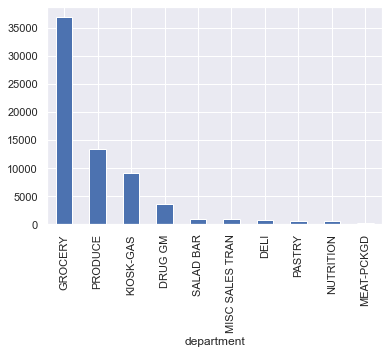

In [20]:
df_max_prod_qty.groupby('department').agg({'quantity':'sum'}).sort_values('quantity',ascending=False).quantity.nlargest(10).plot.bar()
# plt.bar(df_max_prod_qty.department, df_max_prod_qty.quantity)
plt.xticks(rotation=90)
plt.show()

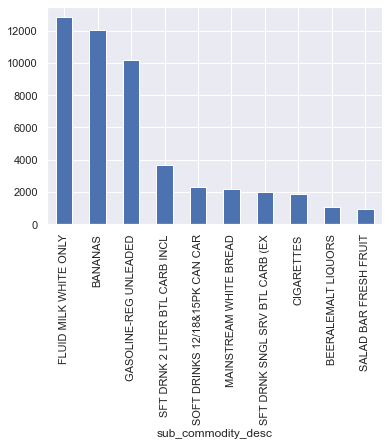

In [21]:
df_max_prod_qty.groupby('sub_commodity_desc').agg({'quantity':'sum'}).sort_values('quantity',ascending=False).quantity.nlargest(10).plot.bar()
plt.xticks(rotation=90)
plt.show()


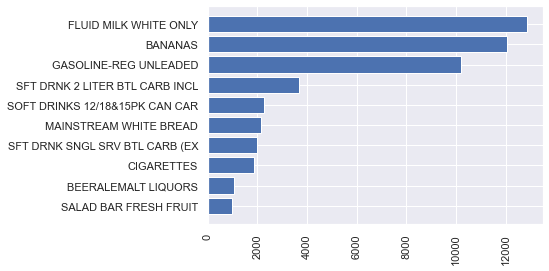

In [22]:
prod_plot = df_max_prod_qty.groupby('sub_commodity_desc').agg({'quantity':'sum'}).sort_values('quantity',ascending=True).quantity.nlargest(10)
prod_plot_df = pd.DataFrame(prod_plot.items(), columns=['category', 'qty']).sort_values('qty',ascending=True)
prod_plot_df

# plot the categories
plt.barh(prod_plot_df.category, prod_plot_df.qty)
plt.xticks(rotation=90)
plt.show()


In [23]:
df_max_prod_qty.commodity_desc.nunique()

147

In [24]:
discount_trans = df_trans.query('retail_disc!=0 or coupon_disc!=0 or coupon_match_disc!=0')
discount_trans1 = df_trans.query('retail_disc!=0')
discount_trans2 = df_trans.query('coupon_disc!=0 or coupon_match_disc!=0')

a_sale = round(discount_trans.sales_value.sum(),2)
a1_dis = round(discount_trans1.retail_disc.sum(),2)
a1_sale = round(discount_trans1.sales_value.sum(),2)
a2_dis = round(discount_trans2.coupon_disc.sum(),2)
a2_sale = round(discount_trans2.sales_value.sum(),2)

print(f'basket with discount {discount_trans.basket_id.nunique()}')
print(f'basket with loyal card discount {discount_trans1.basket_id.nunique()}, total sale {a1_sale}, total discount amount {a1_dis}, ratio {a1_dis/a1_sale}')
print(f'basket with coupon discount {discount_trans2.basket_id.nunique()}, total sale {a2_sale}, total discount amount {a2_dis}, ratio {a2_dis/a2_sale}')
print(f'total basket {df_trans.basket_id.nunique()}, total sale {a_sale}')

basket with discount 231045
basket with loyal card discount 230562, total sale 4056112.59, total discount amount -1398334.84, ratio -0.3447475406495065
basket with coupon discount 16751, total sale 127404.69, total discount amount -42611.54, ratio -0.3344581741849535
total basket 276484, total sale 4108963.23


In [25]:
df_prod.shape
df_prod.department.nunique()

44